# Proyecto
## Experimento #02
### Estimar tamaño de un campo de grama

- **Nombre:** Ernesto Menendez
- **Carnet:** 20072392


### Descripción

Este experimento en consiste estimar el tamaño del campo de grama usando el tamaño de los tallos en una imagen dada.
Luego, podemos usar esta estimación y combinar con los resultados del experimento #01 para inferir la cantidad de
hojas de grama en un campo de golf.

### Librerias

In [421]:
from util import read_jpg, plt_show, as_grayscale

import numpy as np
import cv2

### Imagen original

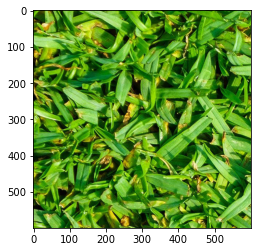

In [422]:
img = read_jpg("grama3")
plt_show(img)

### Pre-procesamiento de la imagen

#### Suavizado y binarización

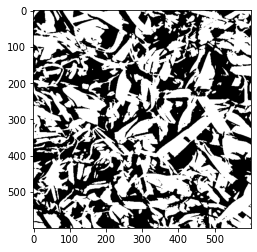

In [423]:
blur = cv2.GaussianBlur(img, (3, 3), 0)
gray = as_grayscale(blur)
ret, otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt_show(otsu)

#### Erosión y dilatación

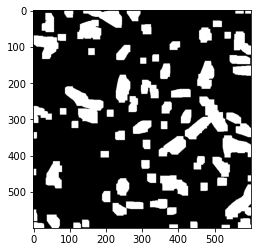

In [424]:
morph_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
eroded = cv2.erode(otsu, morph_kernel, iterations=4)
dilated = cv2.dilate(eroded, morph_kernel, iterations=4)
plt_show(dilated)

#### Encontrar contornos

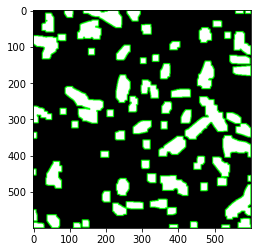

In [425]:
contours, hierarchy = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
bgr_dilated = cv2.cvtColor(dilated, cv2.COLOR_GRAY2BGR)
dilated_contours = cv2.drawContours(bgr_dilated, contours, -1, (0, 255, 0), thickness=2)
plt_show(dilated_contours)

#### Usar contornos para encontrar rectángulos de área mínima

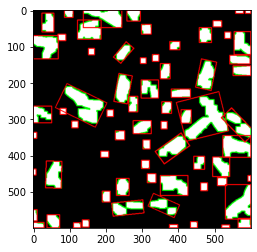

In [426]:
rects = []

for contour in contours:
    box = cv2.boxPoints(cv2.minAreaRect(contour))
    box = np.int32(box)
    rects.append(box)
    dilated_contours = cv2.drawContours(dilated_contours, [box], 0, (0,0,255), 2)

plt_show(dilated_contours)

#### Aislar los rectangulos que mejor representen las hojas de grama

Se recorren los rectangulos de interes de forma eficiente para determinar que rectangulos que mejor
representan las hojas de grama usando las siguientes caracteristicas:
    - El rectangulo tiene una proporcion que caracterize una hoja de grama.
    - El rectangulo contiene un porcentaje alto de color blanco.

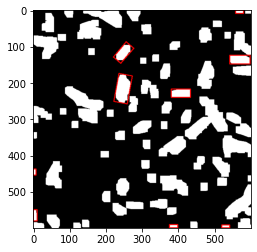

In [427]:
def box_sides(box: np.ndarray) -> (np.float64, np.float64):
    x0, y0 = box[0]
    x1, y1 = box[1]
    x2, y2 = box[2]
    d1 = np.sqrt(np.square(x1 - x0) + np.square(y1 - y0))
    d2 = np.sqrt(np.square(x2 - x1) + np.square(y2 - y1))
    return d1, d2

mat = dilated
rects_hoja = []

for rect in rects:
    # proporcion del rectangulo que caracterize a una hoja de grama
    d1, d2 = box_sides(rect)
    tiene_proporcion_hoja = (d1 > d2*2) if d1 > d2 else (d2 > d1*2)

    if tiene_proporcion_hoja:
        # porcentaje de blanco
        negro = 0
        blanco = 0
        x,y,w,h = cv2.boundingRect(rect)
        for (i, j) in ((i, j) for i in range(y, min(y+h, mat.shape[0]-1))
                              for j in range(x, min(x+w, mat.shape[1]-1))):
            if cv2.pointPolygonTest(rect, (j, i), False) > 0:
                color = mat[i, j]
                if color == 0:
                    negro += 1
                else:
                    blanco += 1

        porcentaje_blanco = blanco / (negro + blanco)

        if porcentaje_blanco > 0.72:
            rects_hoja.append(rect)

bgr_mat = cv2.cvtColor(mat, cv2.COLOR_GRAY2BGR)
for rect_hoja in rects_hoja:
    cv2.drawContours(bgr_mat, [rect_hoja], 0, (0,0,255), 2)

plt_show(bgr_mat)

#### Obtener el ancho de las hojas de grama más reconocibles dentro de la imagen

Para hacerlo simple, se escoge el rectángulo con mayor área.

In [428]:
ancho = None

if len(rects_hoja) > 0:
    max_area = 0
    max_rect_hoja = None
    for rect_hoja in rects_hoja:
        d1, d2 = box_sides(rect_hoja)
        area = d1 * d2
        if area > max_area:
            max_area = area
            max_rect_hoja = rect_hoja

    if max_area > 0:
        d1, d2 = box_sides(max_rect_hoja)
        ancho = d1 if d1 < d2 else d2

### Estimar tamaño del campo de grama de la imagen

Se asume el ancho de una hoja de grama promedio es de 0.7 centimetros.
    - Escala 1:1 -> 0.7cm = 37 pixeles

In [429]:
if ancho > 0:
    px = ancho
    cm = px*0.7/37
    escala = 0.7/cm
    area_img = (img.shape[0] * img.shape[1])*0.49/1369*escala
    print(f"ancho de hoja: {px:.2f}px")
    print(f"escala: {escala:.2f}x")
    print(f"area del campo de la imagen: {area_img:.2f}cm^2")

ancho de hoja: 37.66px
escala: 0.98x
area del campo de la imagen: 126.61cm^2
